In [ ]:
'''
Please make sure that 's140.csv' is in the same directory as this file to run this notebook

'''

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from collections import Counter
from string import punctuation
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,precision_score,recall_score,classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
import tweepy
from collections import Counter
import requests
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bun233\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#ignore warnings for better presentation
warnings.filterwarnings('ignore')
RANDOM_SEED=288

In [3]:
raw=pd.read_csv('s140.csv',header=None)

In [4]:
raw

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [5]:
#tweet_tokenizer = TweetTokenizer()
tweets_tokenised=[word_tokenize(i.lower()) for i in raw[5].tolist()]
#for i in tweets_tokenised:
    #if i=="n't":
    #    ''.join(tweets_tokenised[tweets_tokenised.index(i)-1:tweets_tokenised.index(i)])
tweets_label=raw[0].tolist()
print(Counter(tweets_label))

Counter({0: 800000, 4: 800000})


In [6]:
#pre-processing
tweets_cleaned=tweets_tokenised
for tweet in range(len(tweets_tokenised)):
    tweet_cleaned=[]
    for word in tweets_tokenised[tweet]: #normalise abbreviations and terminologies
        word=word.replace('-','')
        word=word.replace('.','')
        #word=word.replace("'",'')
        if word not in list(punctuation): #remove punctuation
            #if word not in stopwords.words('english'):
                if len(word)>1: #store words with 1 or more letters
                    tweet_cleaned.append(word)
    tweets_cleaned[tweet]=tweet_cleaned
    
s140_processed=[' '.join(tweets_cleaned[i]) for i in range(len(tweets_cleaned))]


In [7]:
#train test split
train_tweets,test_tweets,train_label,test_label=train_test_split(s140_processed,tweets_label,test_size=0.2,random_state=RANDOM_SEED)

              precision    recall  f1-score   support

           0       0.77      0.81      0.79    159894
           4       0.80      0.76      0.78    160106

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



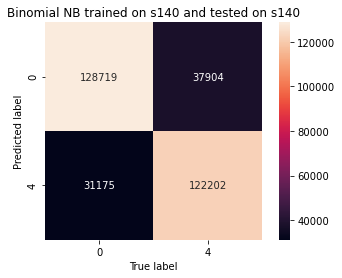

In [8]:
#model building and testing
model_NB_s140 = make_pipeline(TfidfVectorizer(), BernoulliNB())
model_NB_s140.fit(train_tweets,train_label)
NB_pred=model_NB_s140.predict(test_tweets)

print(classification_report(test_label,NB_pred))
mat = confusion_matrix(test_label,NB_pred)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d",xticklabels=[0,4],yticklabels=[0,4]) 
plt.title('Binomial NB trained on s140 and tested on s140')
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

In [9]:
#save the NB model
pkl_filename = "NB_s140.pkl"
with open(pkl_filename, 'wb') as file: 
    pickle.dump(model_NB_s140, file)

In [ ]:
'''Part 1 of Case Study Starts Here'''

In [10]:
#define function for sentiment analysis
def get_sentiment(query):
    #extract tweets 
    bearer_token='AAAAAAAAAAAAAAAAAAAAAOmoXwEAAAAAJ%2B%2BwC5n8XBmtAzrVT9QXGVTutjM%3DlL5gzaFf2BwBSSR3Ux760lERA0VbsaeRaUbzlQdIwf9PsJyQ6c'
    client = tweepy.Client(bearer_token=bearer_token)

    with open('NB_s140.pkl','rb') as file:
        nb_model=pickle.load(file)
    
    tweets = client.search_recent_tweets(query=query, max_results=100)
    text=[]
    label=[]
    for tweet in tweets.data:
        
        #apply the same pre-processing as the training dataset for consistency
        tokenised=[i.lower() for i in word_tokenize(tweet.text) if i not in stopwords.words('english')]
        sentence=[' '.join(i for i in tokenised if len(i)>1)]
        text.append(sentence)
        label.append(nb_model.predict(sentence)[0])

    #combined=[]
    #for t,l in zip(text,label):
    #    combined.append([t,l])

    df_sentiment=pd.concat([pd.DataFrame({'tweet':text}),pd.DataFrame({'label':label})],axis=1)

    return df_sentiment

In [11]:
#define function keywords extraction
def get_keywords(dataframe,sentiment):

    #convert dataframe to list of lists, and then to list of strings
    #some variable names are misleading
    tweets_neg=dataframe.loc[dataframe['label']==sentiment]['tweet'].tolist()
    tweets_neg_list=[]
    for i in tweets_neg:
        for k in i:
            tweets_neg_list.append(k)
    tweets_neg_list=list(set(tweets_neg_list))
    print('Raw tweets: ','\n',tweets_neg_list)

    #compute and present the TF-IDF score for each word
    #the following 4 lines are taken from https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275#:~:text=What%20is%20TF%2DIDF%20and,we%20usually%20name%20a%20corpus.
    tfidf_vec=TfidfVectorizer(use_idf=True,stop_words='english')
    tfIdf = tfidf_vec.fit_transform(tweets_neg_list)
    df = pd.DataFrame(tfIdf[0].T.todense(), index=tfidf_vec.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)

    #print (df.head(25))

    return df

In [91]:
#define function for topics extraction
def get_topics(dataframe,sentiment):

    #convert dataframe to list of lists, and then to list of strings
    #some variable names are misleading
    tweets_neg=dataframe.loc[dataframe['label']==sentiment]['tweet'].tolist()
    tweets_neg_list=[]
    for i in tweets_neg:
        for k in i:
            tweets_neg_list.append(k)
    tweets_neg_list=list(set(tweets_neg_list))

    #apply lda
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(tweets_neg_list)
    feature_names = tfidf_vectorizer.get_feature_names()

    lda = LatentDirichletAllocation(n_components=5)
    lda.fit(tfidf)

    topics=[]
    for idx, topic in enumerate(lda.components_):
        a="Topic "+str(idx)+' '+" ".join(feature_names[i] for i in topic.argsort()[:-11:-1])
        topics.append(a)

    return topics

In [92]:
#negative tweets, keywords, and topics for film 'The Northman'
df_northman=get_sentiment('#TheNorthman')
a=get_keywords(df_northman,0)
print ('\n','Keywords: ','\n',a.head(10))
get_topics(df_northman,0)

Raw tweets:  
 ["1/6 ok fully prepared hate thenorthman feared adaptation amleth/hamlet story would generic projection modern cultural fantasies north 've seen hours icy no-man land drunk pillaging vikings abound", 'thenorthman haaaaard', 'la película que toco se llama thenorthman tengo 10 minutos viéndola estoy en twitter el resto hay que ni siquiera decirlo', 'so made decision finally see thenorthman utterly breathtakingly cinematic highs tragic tale story really left feeling hollow this definitely deserves later rewatch film shot valhalla missed mark https //t.co/fk0tnwoxlt', 'review the northman de robert eggers thenorthman roberteggers vikings norse revenge legend review hanger fyp parati https //t.co/y6fsxthjut', 'watching thenorthman empty theater', 'give fuck anyone says thenorthman is art https //t.co/a8tlrhi37v', 'kinda want watch tomorrow .. thenorthman', 'rt scotchnoblemen 👑how team feeling i64studionfts stream 9:30pm eastern standard time👑 so much is happening tonight if t

['Topic 0 haaaaard thenorthman tonight scotchnoblemen eastern standard stream team th time',
 'Topic 1 https art says fuck a8tlrhi37v thenorthman rogelio carlos nic diaz',
 'Topic 2 theater watching thenorthman northman https haaaaard feeling vikings story tomorrow',
 'Topic 3 thenorthman northman https feeling vikings haaaaard story tomorrow watch want',
 'Topic 4 review kinda watch want tomorrow que thenorthman y6fsxthjut robert revenge']

In [93]:
#positive tweets, keywords, and topics for film 'The Northman'
a=get_keywords(df_northman,4)
print ('\n','Keywords: ','\n',a.head())
get_topics(df_northman,4)

Raw tweets:  
 ["rt obama_llama_fur the thenorthmanfilm may favorite movie year far really enjoyed story it 's something shoul…", 'rt timlammersfilms audio reviewing theatrical release thenorthman streaming series theoffer paramount+ kqrsbarnard on…', 'close read diabolical incest scene thenorthman roxana_hadadi https //t.co/hfr4wvubox', 'rt hackthemovies robert eggers youtube thenorthman https //t.co/93wp8ielql', 'on way watch thenorthman https //t.co/gd3niccghi', '5/6 separate retellings north thenorthman love letter mythic scandinavian tales inspire dramatizing harsh realities medieval life folk hero search truth past well future', 'rt mickylafferty saw thenorthman tonight bloody brutal bloody brilliant robert eggers delivers amazing revenge story incre…', 'rt connormovies nicole kidman monologue thenorthman better entire performance being ricardo https //t.co/oz4ce…', 'rt kevinrbrackett this week reelspoilers robert eggers viking epic thenorthman we talk stellar cast stunning v…', 

['Topic 0 https thenorthman screen film rt big playing seen theaters star',
 'Topic 1 watch https thenorthman en el 2022 sobre way gd3niccghi rt',
 'Topic 2 thenorthman rt eggers bloody robert https tonight going northman saw',
 'Topic 3 scene incest hfr4wvubox close read roxana_hadadi diabolical thenorthman https big',
 'Topic 4 thank thenorthman eggers rt robert costumes cinema toxic loud certified']

In [15]:
#define function for computing ratings according to the proportion of positive sentiment detected
def get_rating(dataframe):
    sentiment=dataframe['label'].tolist()
    proportion=list(map(list,Counter(sentiment).items()))
    rating_by_sentiment=round(proportion[0][1]/(proportion[0][1]+proportion[1][1])*10,1)
    return rating_by_sentiment

In [79]:
print('The rating of The Northman via sentiment analysis: ',get_rating(df_northman))
print('The rating of The Northman according to IMDb: 7.9')

The rating of The Northman via sentiment analysis:  9.2
The rating of The Northman according to IMDb: 7.9


In [ ]:
'''Part 2 of Case Study Starts Here'''

In [18]:
#crawl film titles and ratings from imdb
url='https://www.imdb.com/chart/moviemeter/?ref_=tt_ov_pop'
home = requests.get(url)
soup = BeautifulSoup(home.content, "html.parser")
main=soup.find(id='main')
working=main.find('div',class_='article').find('table',class_='chart full-width').find('tbody',class_='lister-list')
title_columns=working.find_all('td',class_='titleColumn')
titles=[i.find('a').text for i in title_columns]
unwanted_titles=[titles[2],titles[9],titles[12],titles[27],titles[40],titles[51],titles[60],titles[64],titles[76],titles[80],titles[82],titles[88]]
#wanted_titles=[i for i in titles if i not in unwanted_titles]

#unwanted titles are films with blank ratings, in which case the crawled rating is a duplicate of its predecessor
#and thus should be removed
ratings=[]
for i in soup.find_all('td',class_='ratingColumn imdbRating'):
    try:
        rating=i.find('strong').text
    except:
        pass
    ratings.append(rating)
unwanted_ratings=[ratings[2],ratings[9],ratings[12],ratings[27],ratings[40],ratings[51],ratings[60],ratings[64],ratings[76],ratings[80],ratings[82],ratings[88]]

wanted=[] #pairs of wanted titles and ratings
for w,r in zip(titles,ratings):
    if w not in unwanted_titles:
        wanted.append([w,r])

#store and normalise the titles so that they can be used for api query        
wanted_titles=[i[0] for i in wanted]
wanted_titles=[i.replace(":",'') for i in wanted_titles]
wanted_titles=[i.replace(".",'') for i in wanted_titles]
wanted_titles=[i.replace("-",'') for i in wanted_titles]

wanted_ratings=[float(i[1]) for i in wanted]



In [74]:
#years crawled and stored corresponding to the wanted titles
years=[]
for i in title_columns:
    years.append(i.find('span',class_='secondaryInfo').text[1:5])

unwanted_years=[years[2],years[9],years[12],years[27],years[40],years[51],years[60],years[64],years[76],years[80],years[82],years[88]]
wanted_years_pair=[]
for t,y in zip(titles,years):
    if t not in unwanted_titles:
        wanted_years_pair.append([t,int(y)])

wanted_years=[i[1] for i in wanted_years_pair]

In [78]:
#check consistency
len(wanted_years)==len(wanted_titles)

True

In [19]:
#calculate the rating for each film based on detected sentiment
ratings_by_sentiment=[]
for i in wanted_titles:

    #try and except are simply for debugging
    try:
        df=get_sentiment(i)
    except:
        print('error: ',wanted_titles[wanted_titles.index(i)])
        break
    rating_by_sentiment=get_rating(df)
    ratings_by_sentiment.append(rating_by_sentiment)

In [52]:
#prepare datasets with corresponding index for plotting consistency
def get_freq(mini_list):
    return mini_list[0]

#store ratings from imdb and sentiment analysis in the form of imdb (e.g., n out of 10)
ratings_compare=[]
for imdb,sa in zip(wanted_ratings,ratings_by_sentiment):
    ratings_compare.append([imdb,sa])
ratings_compare.sort(key=get_freq,reverse=True)

wanted_pairs=[]
for imdb,title in zip(wanted_ratings,wanted_titles):
    wanted_pairs.append([imdb,title])
wanted_pairs.sort(key=get_freq,reverse=True)

titles_plot=[i[1] for i in wanted_pairs]

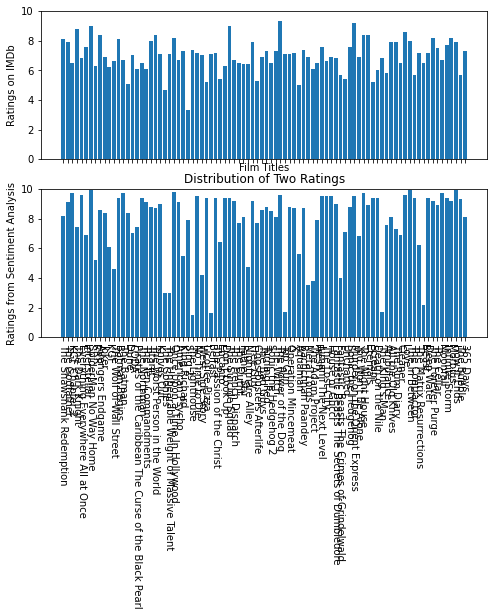

In [95]:
%matplotlib inline

#bar charts
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6), sharex=True)

ax1.set_ylim([0,10])
ax1.bar(titles_plot,wanted_ratings)
ax1.set_ylabel("Ratings on IMDb")
ax1.set_xlabel("Film Titles")

ax2.set_ylim([0, 10])
ax2.bar(titles_plot,ratings_by_sentiment)
ax2.set_ylabel("Ratings from Sentiment Analysis")
plt.title('Distribution of Two Ratings')
plt.xticks(rotation=270)
plt.show()

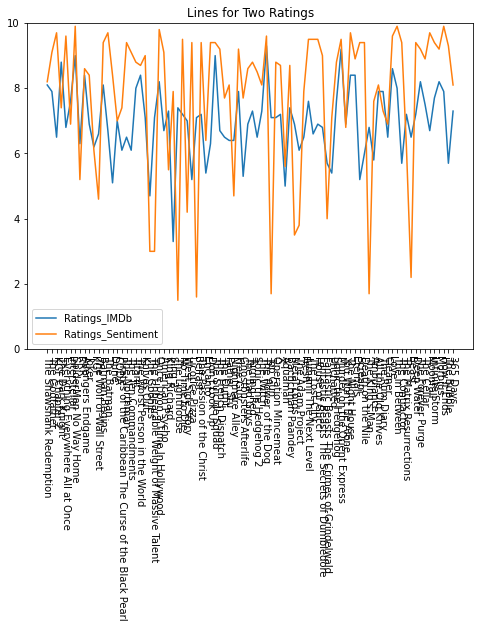

In [114]:
%matplotlib inline

#Line chart
fig, ax = plt.subplots(1,figsize=(8,6))
ax.plot(titles_plot,wanted_ratings)
ax.plot(titles_plot,ratings_by_sentiment)
ax.set_ylim([0, 10])
ax.legend(['Ratings_IMDb','Ratings_Sentiment'])
plt.title('Lines for Two Ratings')
plt.xticks(rotation=270)
plt.show()

In [53]:
#revert the stored pairs of ratings back to the form of sentiment analysis labels (e.g., 0 for negative, 4 for positive)
for i in ratings_compare:
    if i[0]<=5.5:
        i[0]=0
    else:
        i[0]=4
    if i[1]<=5.5:
        i[1]=0
    else:
        i[1]=4


In [62]:
#find the films with contradictory sentiment classes
odd_films=[]
for i in range(0,len(ratings_compare)):
    if ratings_compare[i][0]!=ratings_compare[i][1]:
        odd=titles_plot[i]
        odd_films.append(odd)

odd_films

['Sing 2',
 'No Time to Die',
 'Father Stu',
 'Nightmare Alley',
 'Free Guy',
 'Turning Red',
 'The Power of the Dog',
 'Bachchhan Paandey',
 'The Lost City',
 'The Night House',
 'Scream',
 'Death on the Nile',
 'Cleaner',
 'The Contractor',
 'Deep Water',
 'The Forever Purge',
 'The Cellar',
 'Moonfall',
 'Infinite Storm',
 'Morbius',
 'How It Ends',
 '365 Days']

In [98]:
#most contradictory results come from very recent films
odd_pairs=[]
for i in wanted_years_pair:
    if i[0] in odd_films:
        print(i)
        odd_pairs.append(i)

['Death on the Nile', 2022]
['The Lost City', 2022]
['Morbius', 2022]
['Father Stu', 2022]
['No Time to Die', 2021]
['365 Days', 2020]
['Sing 2', 2021]
['Turning Red', 2022]
['Moonfall', 2022]
['Nightmare Alley', 2021]
['Deep Water', 2022]
['Scream', 2022]
['The Cellar', 2022]
['Free Guy', 2021]
['How It Ends', 2018]
['The Power of the Dog', 2021]
['Cleaner', 2007]
['The Contractor', 2022]
['The Forever Purge', 2021]
['Infinite Storm', 2022]
['Bachchhan Paandey', 2022]
['The Night House', 2020]


In [116]:
%matplotlib inline

odd_films_plot=[i[0] for i in odd_pairs]
odd_years=[i[1] for i in odd_pairs]
lol_odd_years=list(map(list,Counter(odd_years).items()))
odd_years_plot=[i[0] for i in lol_odd_years]
odd_years_freq=[i[1] for i in lol_odd_years]

lol_wanted_years=list(map(list,Counter(wanted_years).items()))
wanted_years_plot=[i[0] for i in lol_wanted_years]
wanted_years_freq=[i[1] for i in lol_wanted_years]

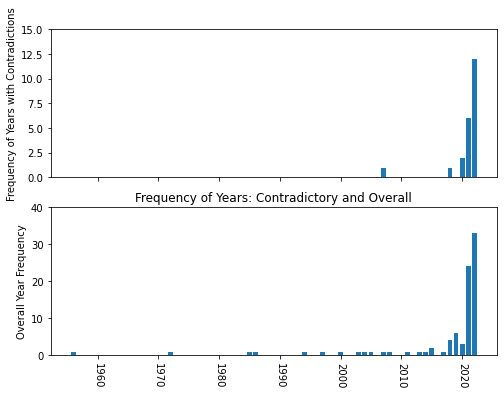

In [121]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6), sharex=True)

ax1.set_ylim([0,15])
ax1.bar(odd_years_plot,odd_years_freq)
ax1.set_ylabel("Frequency of Years with Contradictions")

ax2.set_ylim([0, 40])
ax2.bar(wanted_years_plot,wanted_years_freq)
ax2.set_ylabel("Overall Year Frequency")
plt.title('Frequency of Years: Contradictory and Overall')
plt.xticks(rotation=270)
plt.show()

In [135]:
#find significantly contradictory years by contradiction rate
a=[]
for i in lol_wanted_years:
    if i[0] in odd_years_plot:
        a.append(i)
a.sort(key=get_freq,reverse=True)
lol_odd_years.sort(key=get_freq,reverse=True)

percentage_contratiction=[]
for i in range(0,len(lol_odd_years)):
    percentage=round(lol_odd_years[i][1]/a[i][1],2)
    percentage_contratiction.append(percentage)
    if percentage>=0.5:
        print(str(percentage),' contradiction rate at year ',str(lol_odd_years[i][0]))

0.67  contradiction rate at year  2020
1.0  contradiction rate at year  2007


In [136]:
#find the corresponding films
for i in odd_pairs:
    if i[1] in [2020,2007]:
        print(i)

['365 Days', 2020]
['Cleaner', 2007]
['The Night House', 2020]
